In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import pickle as pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
#from pysynphot import observation
#from pysynphot import spectrum
import forwardmodel
import ciamod
import band
import TPmod
import cloud

In [132]:
# start with the wavelength range
w1 = 0.8
w2 = 15


# How many patches & clouds do we want??
# Must be at least 1 of each, but can turn off cloud below
npatches = 1
nclouds = 1

# set up array for setting patchy cloud answers
do_clouds = np.zeros([npatches],dtype='i')

# Which patches are cloudy
do_clouds[:] = 1

# set up cloud detail arrays
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudtype =np.zeros([npatches,nclouds],dtype='i')

# Now fill cloud details. What kind of clouds and shape are they?
# Cloud types
# 1:  slab cloud
# 2: deep thick cloud , we only see the top
# 3: slab with fixed thickness log dP = 0.005 (i.e. fits within a single layer)
# 4: deep thick cloud with fixed height (i.e. appears in a single layer)
# In both cases the cloud properties are density, rg, rsig for real clouds
# and dtau, w0, and power law for cloudnum = 89 or 99 for grey
cloudnum[:,0] = 5
#cloudnum[:,1] = 1

cloudtype[:,0] = 3
#cloudtype[:,1] = 4

#The cloud properties are set in cloudparams
cloudparams = np.zeros([5,npatches,nclouds],dtype='d')
# Cloud optical depth for types 1 or 3, numbers 89 and 99 (else this is density)
cloudparams[0,:,0] =  10.
# cloud top for all types (log P (bar))
cloudparams[1,:,0] = -1.5
# cloud height (dlog P)
cloudparams[2,:,0] = 0.005
# cloud single scattering albedo / a for hansen distribution
cloudparams[3,:,0] = -1.
# optical depth index for non-grey cloud (cloud number = 89) / b for hansen distribution
cloudparams[4,:,0] = 0.1

# Cloud optical depth for types 1 or 3, numbers 89 and 99 (else this is density)
#cloudparams[0,:,1] = 1.0
# cloud top for all types (log P (bar))
#cloudparams[1,:,1] = 0.02277
# cloud height (dlog P)
#cloudparams[2,:,1] = 0.005
# cloud single scattering albedo / a for hansen distribution
#cloudparams[3,:,1] = 0.4757
# optical depth index for non-grey cloud (cloud number = 89) / b for hansen distribution
#cloudparams[4,:,1] = 0.1


#What's the cloud covering fraction?
pcover = np.empty(npatches)
pcover[:] = 1.0

# gravity??
logg = 5.0

# distance (parsecs)
dist = 11.35

# scale factor r2d2 from distance 1 Rj radius
r2d2 = (71492e3)**2. / (dist * 3.086e+16)**2.

# Are we doing H- bound-free, free-free continuum opacities?
# (Is the profile going above approx 3000K in the photosphere?)
do_bff = 0

# Set the profile type. If we're using a fixed one. Give the file name
proftype = 9
pfile = "t1700g1000f3.dat"


# set up pressure grids in bar cos its intuitive
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
logfinePress = np.arange(-4.0, 2.4, 0.1)
# forward model wants pressure in bar
#logcoarsePress = np.arange(-4.0, 3.0, 0.5)
coarsePress = pow(10,logcoarsePress)
press = pow(10,logfinePress)
nlayers = press.size

# Where are the cross sections?
# give the full path
xpath = "../Linelists/"

# now the cross sections

# Now list the gases.
# If Na is after K, at the end of the list, alkalis will be tied
# together at Asplund solar ratio. See Line at al (2015)
# Else if K is after Na, they'll be separate

gaslist = ['h2o','co','tio','vo','crh','feh','na','k']
vmrlist = np.array([-3.5,-3.5,-8.0,-8.0,-8.0,-8.0,-7.0,-6.5])
ngas = len(gaslist)

# some switches for alternative cross sections
# Use Mike's Alkalis?
malk = 0
# Use Mike's CH4?
mch4 = 0


In [133]:
print cloudparams

[[[ 1.0e+01]]

 [[-1.5e+00]]

 [[ 5.0e-03]]

 [[-1.0e+00]]

 [[ 1.0e-01]]]


In [134]:
prof = np.full(13,100.)
if (proftype == 9):
    modP,modT = np.loadtxt(pfile,skiprows=1,usecols=(1,2),unpack=True)
    tfit = InterpolatedUnivariateSpline(np.log10(modP),modT,k=1)
    prof = tfit(logcoarsePress)


In [135]:
# set the profile
prof = np.full(13,1700.)
temp = TPmod.set_prof(proftype,coarsePress,press,prof)


Text(0.5,0,u'T / K')

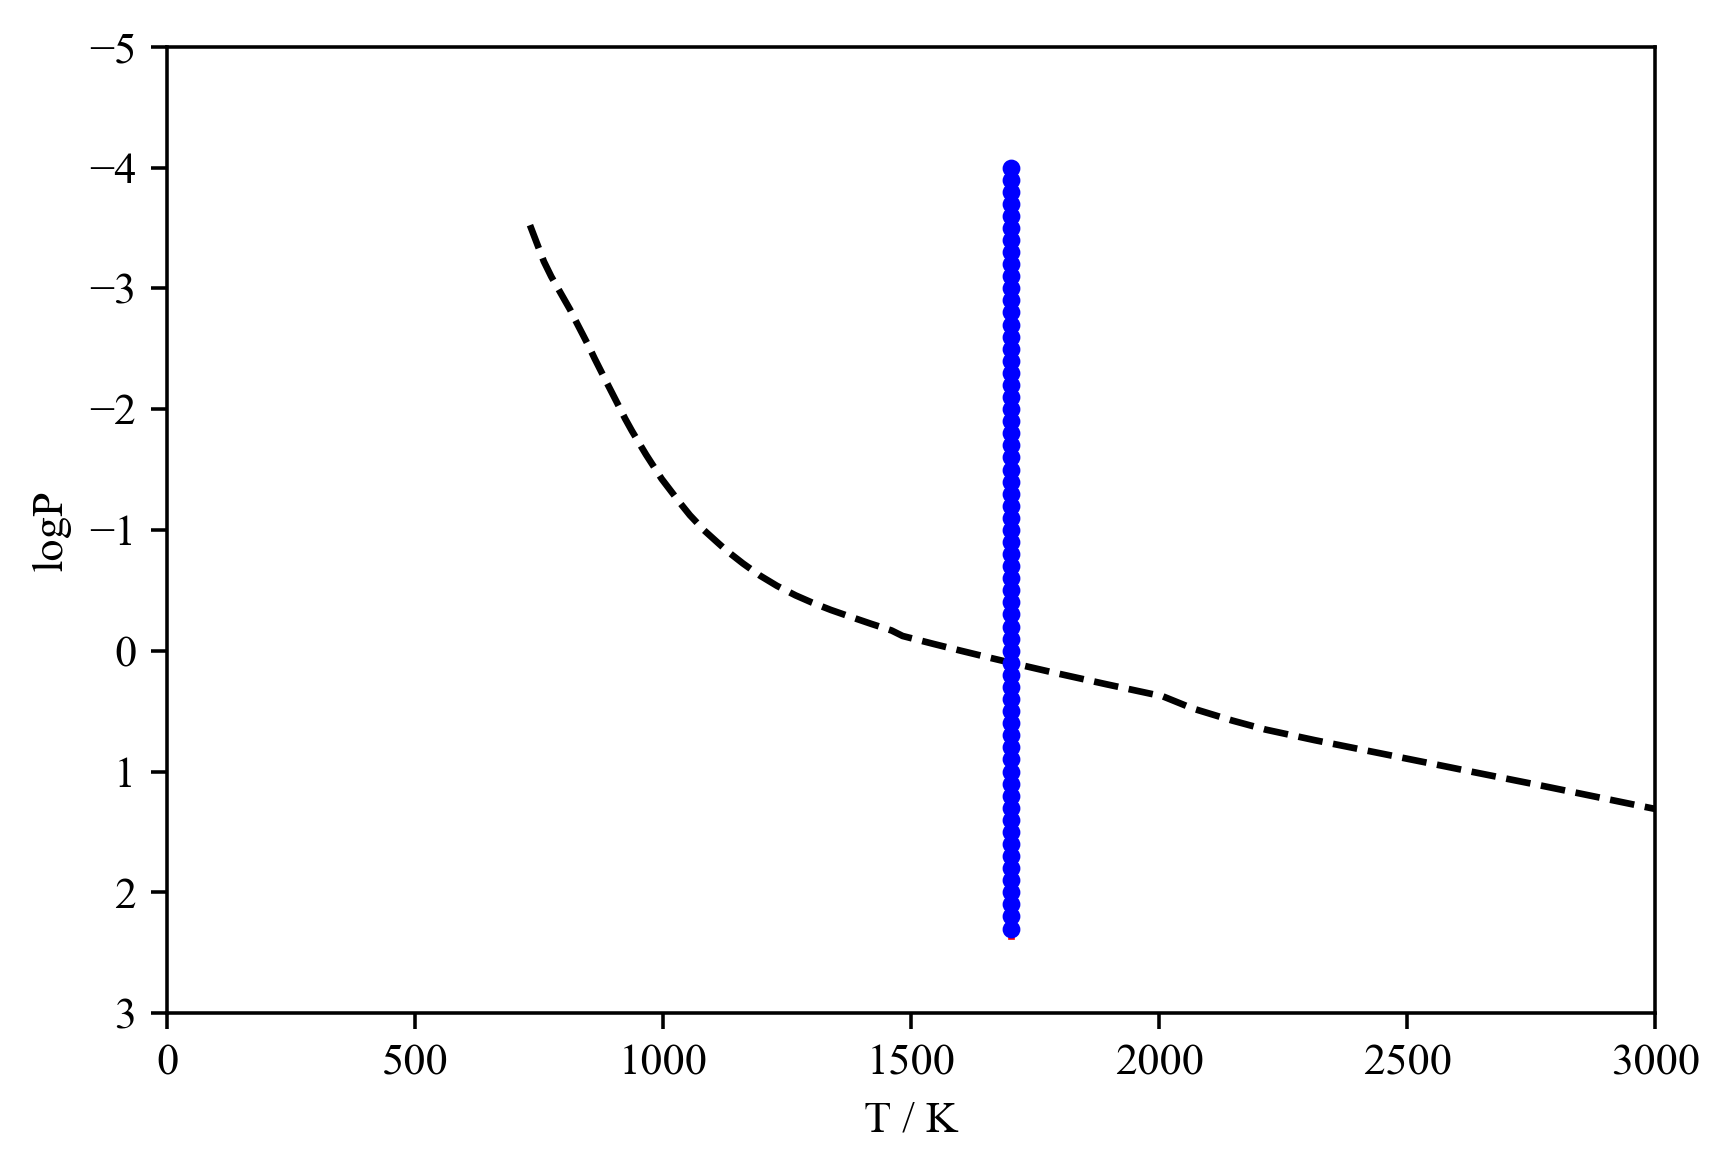

In [136]:
#Tparams = np.array([(0.24961265545013805, 0.29669980226249115, 0.34692402859455584), (0.12282222259062406, 0.15644945610649619, 0.19064094208914834), (-0.229568251913775, 0.16503714060561048, 0.68457833601497942), (3.0008442555754247, 4.1381930691794269, 4.7579819209736272), (4157.089778959039, 4851.2685890221546, 5767.5971072676621)])
#temp = TPmod.set_prof(2,coarsePress,finePress,Tparams[:,1])
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.,3000.,3.0,-5.0])
#plt.plot(miketemp,np.log10(mikepress),'r-')
#plt.plot(temp,np.log10(finePress),'b--')

plt.plot(prof,logcoarsePress,'r-')
plt.plot(modT,np.log10(modP),'k--')
plt.plot(temp,logfinePress,'b.')
plt.ylabel(r'logP')
plt.xlabel('T / K')

#

In [137]:
# now need to translate cloudparams in to cloud profile even
# if do_clouds is zero..

cloudprof,cloudrad,cloudsig = cloud.atlas(do_clouds,cloudnum,cloudtype,cloudparams,press)

cloudprof = np.asfortranarray(cloudprof,dtype = 'float64')
cloudrad = np.asfortranarray(cloudrad,dtype = 'float64')
cloudsig = np.asfortranarray(cloudsig,dtype = 'float64')
pcover = np.asfortranarray(pcover,dtype = 'float32')
cloudnum = np.asfortranarray(cloudnum,dtype='i')
do_clouds = np.asfortranarray(do_clouds,dtype = 'i')

In [138]:
print cloudprof

[[[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [10.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]


In [84]:
# Now we'll get the opacity files into an array
totgas = 24
gasdata = []
with open('gaslist.dat') as fa:
     for line_aa in fa.readlines()[1:totgas+1]:
        line_aa = line_aa.strip()
        gasdata.append(line_aa.split())
    
    
list1 = []    
for i in range(0,ngas):
    for j in range(0,totgas):
            if (gasdata[j][1].lower() == gaslist[i].lower()):
                list1.append(gasdata[j])

if (malk == 1):
    for i in range (0,ngas):    
        list1[i] = [w.replace('K_xsecs.pic', 'K_Mike_xsecs.pic') for w in list1[i]]
        list1[i] = [w.replace('Na_xsecs.pic', 'Na_Mike_xsecs.pic') for w in list1[i]]

if (mch4 ==1):
    for i in range (0,ngas):    
        list1[i] = [w.replace('CH4_xsecs.pic', 'CH4_Mike_xsecs.pic') for w in list1[i]]
    

lists = [xpath+i[3] for i in list1[0:ngas]]
gasnum = np.asfortranarray(np.array([i[0] for i in list1[0:ngas]],dtype='i'))


# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open(xpath+'/H2O_UCL_xsecs.pic', "rb" ) )

wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= press.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(press)))

linelist[np.isnan(linelist)] = -50.0


# Get the cia bits
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')

# Sort out the BFF opacity stuff:

intab = np.loadtxt("2015_06_1060grid_feh_00_co_10.txt",skiprows=1)
test = np.array(intab)
test2 = test.reshape(60,18,36)
Pgrid = test2[20:21,:,1].reshape(18)
Tgrid =  test2[:,10:11,0].reshape(60)
abunds= test2[:,:,2:]
nabpress = 18
nabtemp = 60
nabgas = 34
ab_myP = np.empty([nabtemp,nlayers,nabgas])
for gas in range (0,nabgas):
    for i in range (0,nabtemp):
            pfit = InterpolatedUnivariateSpline(Pgrid,np.log10(abunds[i,:,gas]),k=1)
            ab_myP[i,:,gas] = pfit(np.log10(press))
            
bff_raw = np.empty([nabtemp,nlayers,3])
bff_raw[:,:,0] = ab_myP[:,:,0]
bff_raw[:,:,1] = ab_myP[:,:,2]
bff_raw[:,:,2] = ab_myP[:,:,4]

bfTgrid = Tgrid


In [85]:
# Now get the BFF stuff sorted
bff = np.zeros([3,nlayers],dtype="float64") 
if (do_bff == 1):
    for gas in range(0,3):
        for i in range(0,nlayers):
            tfit = InterpolatedUnivariateSpline(bfTgrid,bff_raw[:,i,gas],k=1) 
            bff[gas,i] = 10.**tfit(temp[i])

bff = np.asfortranarray(bff, dtype='float64')
 

In [139]:
logVMR = np.empty((ngas,nlayers),dtype='d')
for i in range(0,ngas):                              
    logVMR[i,:] = vmrlist[i]
press = np.asfortranarray(press,dtype='float32')
temp = np.asfortranarray(temp,dtype='float64')
logVMR = np.asfortranarray(logVMR,dtype='float64')

In [140]:
print forwardmodel.marv.__doc__

outspec,phot_press,tau_spec,cfunc = marv(temp,logg,r2d2,ingasnum,logvmr,pcover,do_clouds,incloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,inpress,inwavenum,inlinelist,cia,ciatemps,use_disort,make_pspec,make_tspec,make_cf,do_bff,bff)

Wrapper for ``marv``.

Parameters
----------
temp : in/output rank-1 array('d') with bounds (f2py_temp_d0)
logg : input float
r2d2 : input float
ingasnum : in/output rank-1 array('i') with bounds (f2py_ingasnum_d0)
logvmr : in/output rank-2 array('d') with bounds (f2py_logvmr_d0,f2py_logvmr_d1)
pcover : in/output rank-1 array('f') with bounds (f2py_pcover_d0)
do_clouds : in/output rank-1 array('i') with bounds (f2py_do_clouds_d0)
incloudnum : in/output rank-2 array('i') with bounds (f2py_incloudnum_d0,f2py_incloudnum_d1)
cloudrad : in/output rank-3 array('d') with bounds (f2py_cloudrad_d0,f2py_cloudrad_d1,f2py_cloudrad_d2)
cloudsig : in/output rank-3 array('d') with bounds (f2py_cloudsig_d0,f2py_cloudsig_d1,f2py_cloudsig_d2)
cloudprof : in/output rank-3 

In [141]:
# switches for tau spec, phot spec and contribution function
tspec = 0
pspec = 0
make_cf = 0
# other switches; ignore
use_disort = 0
# now we can call the forward model
tmpoutspec,photspec,tauspec,cfunc = forwardmodel.marv(temp,logg,r2d2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort,pspec,tspec,make_cf,do_bff,bff)

# This bit trims off the unused portion of the array
outspec = np.zeros((2,nwave),dtype='d')
outspec[:,:] = tmpoutspec[:,:nwave]

In [142]:
# check some values
print outspec

[[1.49925037e+01 1.49700599e+01 1.49476831e+01 ... 8.00128020e-01
  8.00064005e-01 8.00000000e-01]
 [2.71290474e-17 2.72794786e-17 2.74304965e-17 ... 1.98796526e-16
  2.95459996e-16 1.91745345e-16]]


Text(0.5,0,u'Wavelength / Microns')

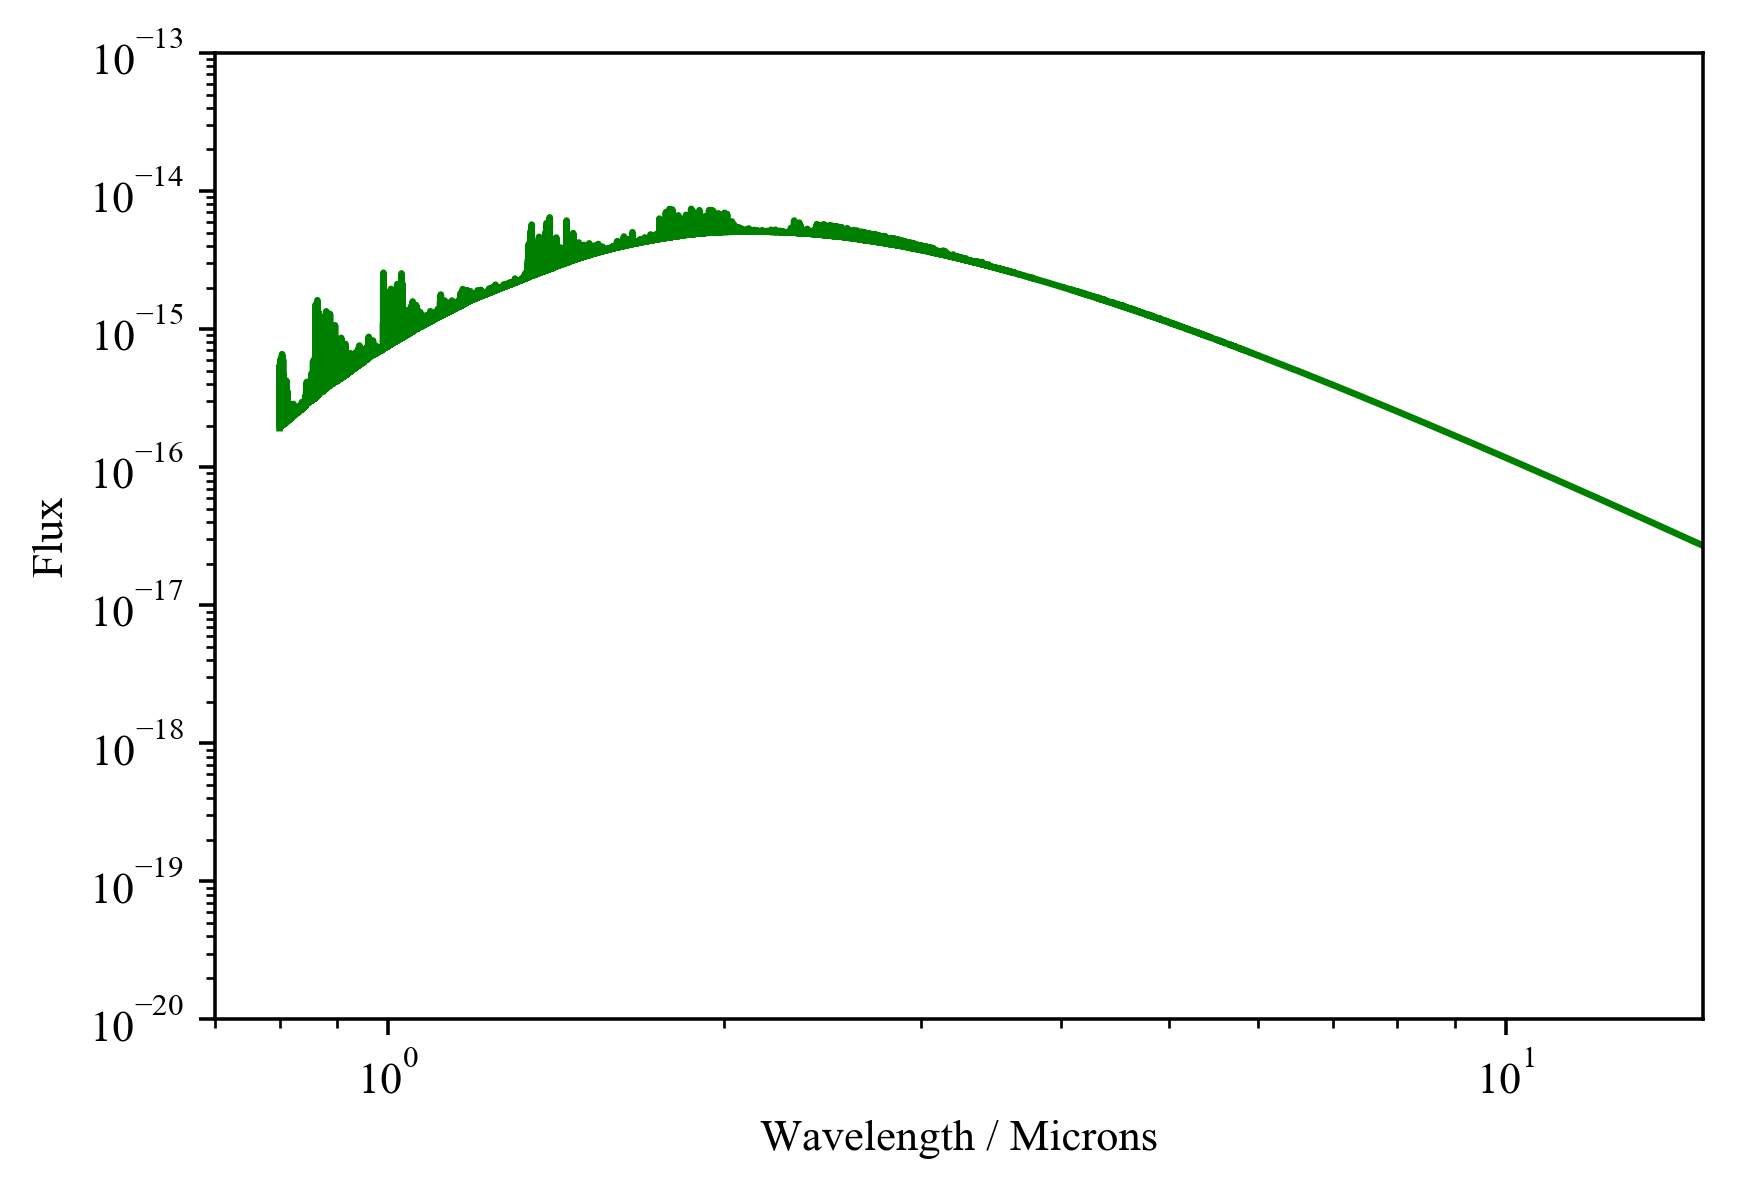

In [143]:
# plot the spectrum to have a look at it
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 15,1e-20,10e-14])

ax = fig.add_subplot(1,1,1)

ax.set_yscale('log')
ax.set_xscale('log')

plt.plot(outspec[0,:],outspec[1,:],'g-')
#plt.plot(outspec_c[0,:],outspec_c[1,:],'r-')

#plt.plot(outspec[0,:],(1.+ ((outspec[1,:]- oldspec[1,:])/outspec[1,:]))*1e5,'g-')

#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
#plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
#plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [116]:
# get the observed spectrum
obspec = np.asfortranarray(np.loadtxt("2M2224_multi1015.txt",dtype='d',unpack='true'))


In [117]:
# This bit convolves the spectrum with a gaussian
wlen = outspec.shape[1]
wint = outspec[0,0] - outspec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int((((fwhm / disp) // 2) * 2) +1)

# now get the kernel and convolve
gauss = Gaussian1DKernel(gwidth)
cspec = convolve(outspec[1,:],gauss,boundary='extend')
spec = np.array([outspec[0,::-1],cspec[::-1]])
    
# rebin to observed dispersion
wfit = sp.interpolate.splrep(spec[0,:],spec[1,:],s=0)
modspec = sp.interpolate.splev(obspec[0,:],wfit,der=0)
    

In [118]:
s2 = obspec[2,::3]**2
lnLik=-0.5*np.sum((((obspec[1,::3] - modspec[::3])**2) / s2) + np.log(2.*np.pi*s2))
print lnLik

-110046.4260218323


Text(0.5,0,u'Wavelength / Microns')

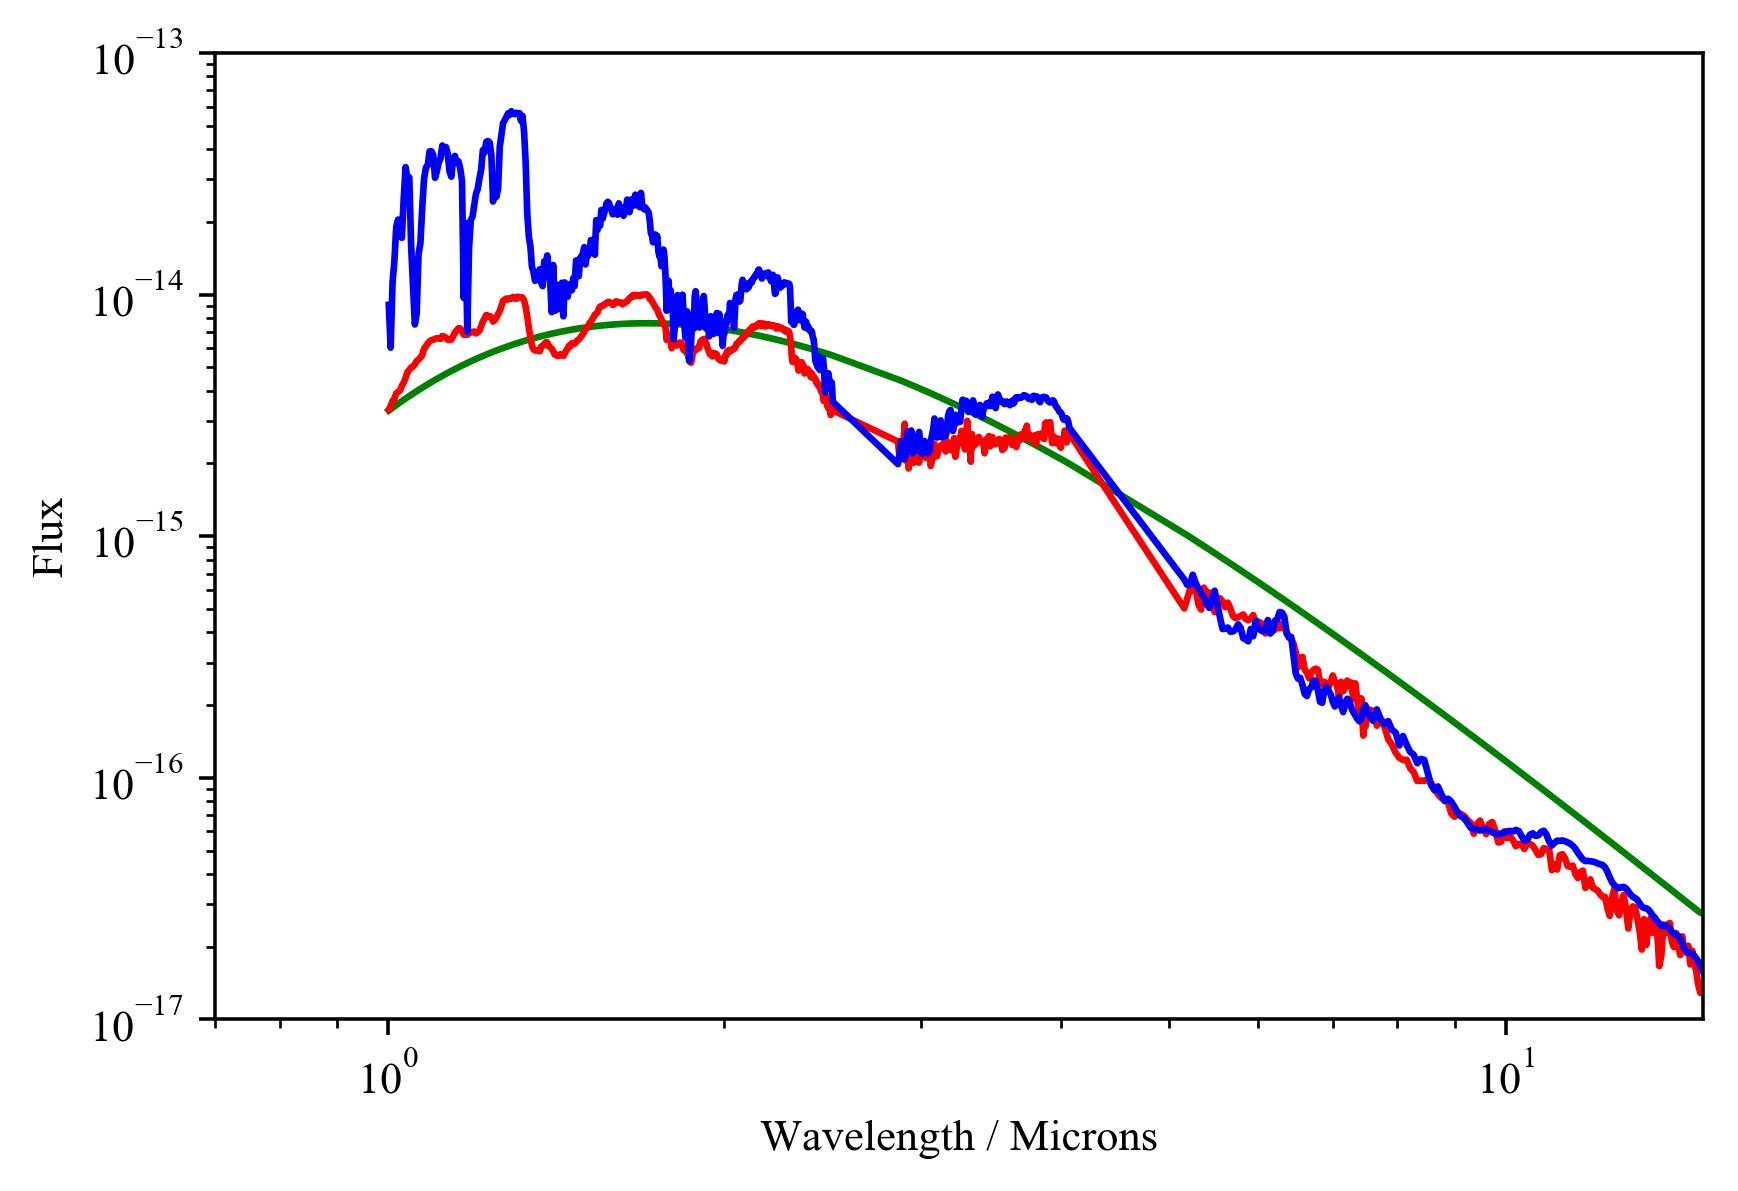

In [119]:
# plot the spectrum to have a look at it
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 15,1e-17,10e-14])

ax = fig.add_subplot(1,1,1)

ax.set_yscale('log')
ax.set_xscale('log')

plt.plot(obspec[0,:],modspec,'g-')
plt.plot(obspec[0,:],obspec[1,:],'r-')
plt.plot(obspec[0,:],oldspec,'b-')

#plt.plot(outspec[0,:],(1.+ ((outspec[1,:]- oldspec[1,:])/outspec[1,:]))*1e5,'g-')

#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
#plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
#plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [45]:
oldspec = modspec